In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from natsort import natsorted
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
from nilearn.image import load_img
from nilearn.surface import vol_to_surf, load_surf_mesh
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import seaborn as sns
from nilearn import datasets, image
import matplotlib.cm as cm
from pygam import LinearGAM, s, f
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
from enigmatoolbox.permutation_testing import spin_test, shuf_test

In [2]:
regions = [
'SSp-n',
'VISp',
'Audp',
'SSp-m',
'SSp-bfd',
'SSp-ul',
'SSp-ll',
'SSs',
'TEa',
'ECT',
'PERI',
'AI',
'MOp',
'RSP',
'MOs',
'ACA',
'PL'] #'PTLp',

In [3]:
hurst = pd.read_csv('../../../Derivatives/mouse/H_structural.csv')
age = pd.read_csv('../../../Dataset/mouse/participants.tsv', sep = '\t')
atlas = pd.read_csv('../../../Dataset/mouse/atlas/atlas.tsv', sep = '\t')

In [4]:
SSp_n = [x for x in atlas.name.values if 'Primary somatosensory area, nose' in x]
VISp = [x for x in atlas.name.values if 'Primary visual area' in x]
Audp =  [x for x in atlas.name.values if 'Primary auditory area' in x]
SSp_m = [x for x in atlas.name.values if 'Primary somatosensory area, mouth' in x]
SSp_bfd = [x for x in atlas.name.values if 'Primary somatosensory area, barrel field' in x]
SSp_ul = [x for x in atlas.name.values if 'Primary somatosensory area, upper limb' in x]
SSp_ll = [x for x in atlas.name.values if 'Primary somatosensory area, lower limb' in x]
SSs = [x for x in atlas.name.values if 'Supplemental somatosensory area' in x]
TEa = [x for x in atlas.name.values if 'Temporal association areas' in x]
ECT  = [x for x in atlas.name.values if 'Ectorhinal area' in x]
PERI = [x for x in atlas.name.values if 'Perirhinal area' in x]
AI = [x for x in atlas.name.values if 'Agranular insular area' in x]
MOp = [x for x in atlas.name.values if 'Primary motor area' in x]
RSP = [x for x in atlas.name.values if 'Retrosplenial area' in x]
#PTLp = [x for x in atlas.name.values if 'Posterior parietal association areas' in x]
MOs = [x for x in atlas.name.values if 'Secondary motor area' in x]
ACA = [x for x in atlas.name.values if 'Anterior cingulate area' in x]
PL = [x for x in atlas.name.values if 'Prelimbic area' in x]
#FRP = [x for x in atlas.name.values if 'Frontal pole, cerebral cortex' in x]

In [5]:
sa = []
for x in atlas['name'].values:
    if x in SSp_n:
        sa.append(0)
    elif x in VISp:
        sa.append(1)
    elif x in Audp:
        sa.append(2)
    elif x in SSp_m:
        sa.append(3)
    elif x in SSp_bfd:
        sa.append(4)
    elif x in SSp_ul:
        sa.append(5)
    elif x in SSp_ll:
        sa.append(6)
    elif x in SSs:
        sa.append(7)
    elif x in TEa:
        sa.append(8)
    elif x in ECT:
        sa.append(9)
    elif x in PERI:
        sa.append(10)
    elif x in AI:
        sa.append(11)
    elif x in MOp:
        sa.append(12)
    elif x in RSP:
        sa.append(13)
    #elif x in PTLp:
    #    sa.append(14)
    elif x in MOs:
        sa.append(14)
    elif x in ACA:
        sa.append(15)
    elif x in PL:
        sa.append(16)
    #elif x in FRP:
    #    sa.append(17)
    else:
        sa.append(-1)

In [6]:
H = hurst.T.iloc[:604, :]
H['sa'] = sa
hurst = pd.concat([H.iloc[:, :-1].T, age], axis=1)
H = H[H.sa>-1]

In [7]:
mmc3 = pd.read_csv('../../../Dataset/mouse/celldensity/mmc3.csv', header=1)
mmc3 = mmc3[mmc3[' mean ']!=' N/D ']
mmc3 = mmc3[mmc3[' mean .2']!=' N/D ']
mmc3 = mmc3[mmc3[' mean .4']!=' N/D ']
mmc3 = mmc3[mmc3[' mean ']!=' - ']
mmc3 = mmc3[mmc3[' mean .2']!=' - ']
mmc3 = mmc3[mmc3[' mean .4']!=' - ']
mmc3 = mmc3[mmc3[' SD ']!=' N/D ']
mmc3 = mmc3[mmc3[' SD .2']!=' N/D ']
mmc3 = mmc3[mmc3[' SD .4']!=' N/D ']
mmc3 = mmc3[mmc3[' SD ']!=' - ']
mmc3 = mmc3[mmc3[' SD .2']!=' - ']
mmc3 = mmc3[mmc3[' SD .4']!=' - ']
mmc3['PVmean'] = [int(x.replace(',', '')) for x in mmc3[' mean ']]
mmc3['SSTmean'] = [int(x.replace(',', '')) for x in mmc3[' mean .2']]
mmc3['VIPmean'] = [int(x.replace(',', '')) for x in mmc3[' mean .4']]
mmc3['PVsd'] = [int(x.replace(',', '')) for x in mmc3[' SD ']]
mmc3['SSTsd'] = [int(x.replace(',', '')) for x in mmc3[' SD .2']]
mmc3['VIPsd'] = [int(x.replace(',', '')) for x in mmc3[' SD .4']]
regions = [
'SSp-n',
'VISp',
'AUDp',
'SSp-m',
'SSp-bfd',
'SSp-ul',
'SSp-ll',
'SSs',
'TEa',
'ECT',
'PERI',
'AI',
'MOp',
'RSP',
'MOs',
'ACA',
'PL'] #'PTLp',
areas = regions
df_t = pd.DataFrame()
for x in areas:
    df_t = pd.concat([df_t, mmc3[mmc3.ROI==x]])
    print([x,mmc3[mmc3.ROI==x].shape])
df_t = df_t.reset_index(drop=True)
my_palette = {c: sns.color_palette('Blues', n_colors=(4)).as_hex()[c+1] for c in np.arange(3)}
expression = df_t
expression['group'] = regions

['SSp-n', (1, 29)]
['VISp', (1, 29)]
['AUDp', (1, 29)]
['SSp-m', (1, 29)]
['SSp-bfd', (1, 29)]
['SSp-ul', (1, 29)]
['SSp-ll', (1, 29)]
['SSs', (1, 29)]
['TEa', (1, 29)]
['ECT', (1, 29)]
['PERI', (1, 29)]
['AI', (1, 29)]
['MOp', (1, 29)]
['RSP', (1, 29)]
['MOs', (1, 29)]
['ACA', (1, 29)]
['PL', (1, 29)]


In [8]:
df = H[H.sa>-1]
hurst = pd.concat([H.iloc[:, :-1].T, age], axis=1)
hurst = hurst[hurst.dataset == 'aes2']
hurst = hurst[hurst.anesthesia =='iso1']
df['H'] = H.iloc[:, list(hurst.index)].mean(axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.6235188223838366


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      H   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     24.84
Date:                Mon, 20 May 2024   Prob (F-statistic):           0.000163
Time:                        19:54:35   Log-Likelihood:                 33.197
No. Observations:                  17   AIC:                            -62.39
Df Residuals:                      15   BIC:                            -60.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3879      0.024     16.072      0.0

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      H   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     5.326
Date:                Mon, 20 May 2024   Prob (F-statistic):             0.0357
Time:                        19:54:36   Log-Likelihood:                 27.476
No. Observations:                  17   AIC:                            -50.95
Df Residuals:                      15   BIC:                            -49.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8130      0.136      5.966      0.0

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
[0.305, array([ 0.49469219,  0.27582443, -0.55439421, ...,  0.20319627,
        0.15587039, -0.03317254])]


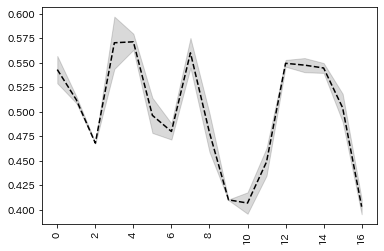

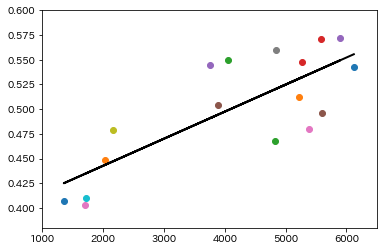

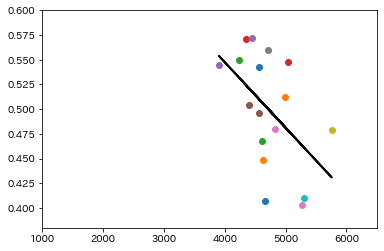

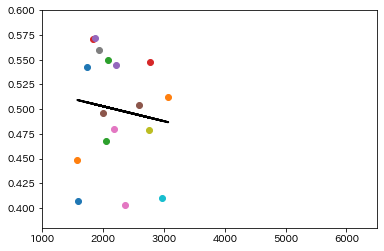

In [9]:
for i in df.columns:
    df[i] = [float(x) for x in df[i]]
my_palette = {c: sns.color_palette('Blues', n_colors=(3)).as_hex()[c+1] for c in np.arange(2)}
df_mean = df.groupby('sa').mean().reset_index()
df_std = df.groupby('sa').sem().reset_index()
m = [df_mean[df_mean.sa==float(x)]['H'].values[0] for x in np.arange(17)]
s = [df_std[df_std.sa==float(x)]['H'].values[0] for x in np.arange(17)]

figure = plt.figure()
plt.plot(np.arange(17), m, '--', color='k')
plt.fill_between(np.arange(17), [x+y for x,y in zip(m,s)], [x-y for x,y in zip(m,s)], alpha=0.15,color='k') 
plt.xticks(rotation=90)
df_mean['group'] = [regions[int(x)] for x in df_mean.sa.values]
plt.savefig('Fig1F_AD1_hurst.eps',  format='eps', bbox_inches='tight')
#plt.ylim([1.565, 1.595])
df_concat = pd.merge(df_mean, expression.iloc[:, -7:].groupby('group').mean().reset_index(),  on='group', how='inner')

for x in ['PVmean', 'SSTmean', 'VIPmean']:
    figure = plt.figure()
    for i in [x for x in np.arange(df_concat.shape[0])]:
        plt.scatter(df_concat[x][i], df_concat['H'][i])
    df_x = pd.DataFrame(df_concat[x])
    df_y = pd.DataFrame(df_concat['H'])
    mod = LinearRegression()
    mod_lin = mod.fit(df_x, df_y)
    y_lin_fit = mod_lin.predict(df_x)
    r2_lin = mod.score(df_x, df_y)
    plt.plot(df_x[x].values, [x[0] for x in y_lin_fit], color = '#000000', linewidth=2)
    print(r2_lin)
    plt.savefig('Fig3E.eps',  format='eps')
    X = sm.add_constant(df_concat[x])
    results = sm.OLS(df_concat['H'],X).fit()
    print(results.summary())
    plt.ylim([0.38, 0.6])
    plt.xlim([1000, 6500])
    #plt.legend(df_concat.group)
    plt.savefig('Fig1F_AD1'+x+'.eps',  format='eps', bbox_inches='tight')
    fc_ctx_p, fc_ctx_d = shuf_test(df_concat[x], df_concat['H'],  type='pearson', n_rot=1000, null_dist=True)
    print([fc_ctx_p, fc_ctx_d])

In [10]:
df = H[H.sa>-1]
hurst = pd.concat([H.iloc[:, :-1].T, age], axis=1)
hurst = hurst[hurst.dataset == 'aes2']
hurst = hurst[hurst.anesthesia =='mediso']
df['H'] = H.iloc[:, list(hurst.index)].mean(axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.02596753415646602
                            OLS Regression Results                            
Dep. Variable:                      H   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.3999
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.537
Time:                        19:54:41   Log-Likelihood:                 30.549
No. Observations:                  17   AIC:                            -57.10
Df Residuals:                      15   BIC:                            -55.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4645      0.028

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
0.254


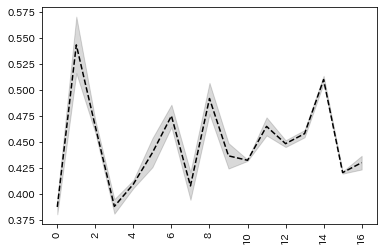

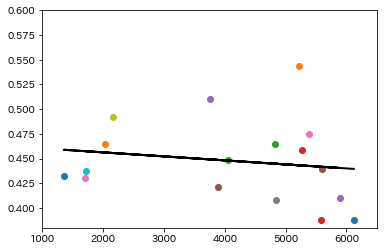

In [11]:
for i in df.columns:
    df[i] = [float(x) for x in df[i]]
my_palette = {c: sns.color_palette('Blues', n_colors=(3)).as_hex()[c+1] for c in np.arange(2)}
df_mean = df.groupby('sa').mean().reset_index()
df_std = df.groupby('sa').sem().reset_index()
m = [df_mean[df_mean.sa==float(x)]['H'].values[0] for x in np.arange(17)]
s = [df_std[df_std.sa==float(x)]['H'].values[0] for x in np.arange(17)]

figure = plt.figure()
plt.plot(np.arange(17), m, '--', color='k')
plt.fill_between(np.arange(17), [x+y for x,y in zip(m,s)], [x-y for x,y in zip(m,s)], alpha=0.15,color='k') 
plt.xticks(rotation=90)
df_mean['group'] = [regions[int(x)] for x in df_mean.sa.values]
plt.savefig('Fig1F_AD1_hurst.eps',  format='eps', bbox_inches='tight')
#plt.ylim([1.565, 1.595])
df_concat = pd.merge(df_mean, expression.iloc[:, -7:].groupby('group').mean().reset_index(),  on='group', how='inner')


for x in ['PVmean']:
    figure = plt.figure()
    for i in [x for x in np.arange(df_concat.shape[0])]:
        plt.scatter(df_concat[x][i], df_concat['H'][i])
    df_x = pd.DataFrame(df_concat[x])
    df_y = pd.DataFrame(df_concat['H'])
    mod = LinearRegression()
    mod_lin = mod.fit(df_x, df_y)
    y_lin_fit = mod_lin.predict(df_x)
    r2_lin = mod.score(df_x, df_y)
    plt.plot(df_x[x].values, [x[0] for x in y_lin_fit], color = '#000000', linewidth=2)
    print(r2_lin)
    plt.savefig('Fig3E.eps',  format='eps')
    X = sm.add_constant(df_concat[x])
    results = sm.OLS(df_concat['H'],X).fit()
    print(results.summary())
    plt.ylim([0.38, 0.6])
    plt.xlim([1000, 6500])
    plt.savefig('Fig1F_AD1'+x+'mediso.eps',  format='eps', bbox_inches='tight')
    fc_ctx_p, fc_ctx_d = shuf_test(df_concat[x], df_concat['H'],  type='pearson', n_rot=1000, null_dist=True)
    print(fc_ctx_p)